In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airbnb-recruiting-new-user-bookings/sample_submission_NDF.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/countries.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip


In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317146 sha256=edb064a9dc4ddf03d80d5ec857dff50ecb675bde86ad04a2c2535f9da2f19532
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


## Data Reading and First-steps

#### Importing the required libraries throughout the notebook.

In [3]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import concat, col, lit
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### SparkSession

In [4]:
from pyspark.sql import SparkSession

# create a SparkSession
spark = SparkSession.builder.appName('P3').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/16 20:27:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Unzipping the datafiles from kaggle, so we can use it and read it using spark.read...

In [5]:
import zipfile

train_file= zipfile.ZipFile('../input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip')
train_file.extractall()

test_file= zipfile.ZipFile('../input/airbnb-recruiting-new-user-bookings/test_users.csv.zip')
test_file.extractall()

sessions_file= zipfile.ZipFile('../input/airbnb-recruiting-new-user-bookings/sessions.csv.zip')
sessions_file.extractall()

age_file= zipfile.ZipFile('../input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip')
age_file.extractall()


#### Reading the training data

In [6]:
train_df = spark.read.format("csv").option("header", "true").load("/kaggle/working/train_users_2.csv")
train_df.show(5)

+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|gxn3p5htnn|          2010-06-28|        20090319043255|              null|-unknown-|null|     facebook|          0|      en|           direct|            direct|              untracked|       Web|      Mac Desktop|       Chrome|                NDF|


#### Reading the testing data

In [7]:
test_df = spark.read.format("csv").option("header", "true").load("/kaggle/working/test_users.csv")
test_df.show(5)

+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|
+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+
|5uwns89zht|          2014-07-01|        20140701000006|              null|   FEMALE|35.0|     facebook|          0|      en|           direct|            direct|              untracked|     Moweb|           iPhone|Mobile Safari|
|jtl0dijy2j|          2014-07-01|        20140701000051|              null|-unkn

#### Reading the session data

In [8]:
sessions_df = spark.read.format("csv").option("header", "true").load("/kaggle/working/sessions.csv")
sessions_df.show(5)

+----------+--------------+-----------+-------------------+---------------+------------+
|   user_id|        action|action_type|      action_detail|    device_type|secs_elapsed|
+----------+--------------+-----------+-------------------+---------------+------------+
|d1mm9tcy42|        lookup|       null|               null|Windows Desktop|       319.0|
|d1mm9tcy42|search_results|      click|view_search_results|Windows Desktop|     67753.0|
|d1mm9tcy42|        lookup|       null|               null|Windows Desktop|       301.0|
|d1mm9tcy42|search_results|      click|view_search_results|Windows Desktop|     22141.0|
|d1mm9tcy42|        lookup|       null|               null|Windows Desktop|       435.0|
+----------+--------------+-----------+-------------------+---------------+------------+
only showing top 5 rows



#### Reading the age data

In [9]:
age_df = spark.read.format("csv").option("header", "true").load("/kaggle/working/age_gender_bkts.csv")
age_df.show(5)

+----------+-------------------+------+-----------------------+------+
|age_bucket|country_destination|gender|population_in_thousands|  year|
+----------+-------------------+------+-----------------------+------+
|      100+|                 AU|  male|                    1.0|2015.0|
|     95-99|                 AU|  male|                    9.0|2015.0|
|     90-94|                 AU|  male|                   47.0|2015.0|
|     85-89|                 AU|  male|                  118.0|2015.0|
|     80-84|                 AU|  male|                  199.0|2015.0|
+----------+-------------------+------+-----------------------+------+
only showing top 5 rows



## Data Exploration

#### In the following 9 cells, we're checking the current parallelism on Kaggle then we re-partition the dataframes to match the parallelism (if any).

In [10]:
spark.sparkContext.defaultParallelism

4

In [11]:
train_df.rdd.getNumPartitions()

4

In [12]:
test_df.rdd.getNumPartitions()

2

In [13]:
test_df = test_df.repartition(4)

In [14]:
test_df.rdd.getNumPartitions()

4

In [15]:
age_df = age_df.repartition(4)

In [16]:
age_df.rdd.getNumPartitions()

4

In [17]:
sessions_df = sessions_df.repartition(4)

In [18]:
sessions_df.rdd.getNumPartitions()

4

In [19]:
train_df.count()

213451

In [20]:
test_df.count()

62096

In [21]:
age_df.count()

420

In [22]:
sessions_df.count()

10567737

In [23]:
train_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_account_created: string (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: string (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)



In [24]:
test_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_account_created: string (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: string (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)



In [25]:
age_df.printSchema()

root
 |-- age_bucket: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- population_in_thousands: string (nullable = true)
 |-- year: string (nullable = true)



In [26]:
sessions_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- action: string (nullable = true)
 |-- action_type: string (nullable = true)
 |-- action_detail: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- secs_elapsed: string (nullable = true)



#### Converting the age column type from string to float in both train_df and test_df

In [27]:
train_df = train_df.withColumn("age", train_df["age"].cast('float'))
test_df = test_df.withColumn("age", test_df["age"].cast('float'))

In [28]:
train_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_account_created: string (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: float (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: string (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)



In [29]:
test_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_account_created: string (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: float (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: string (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)



#### Converting the signup_flow column type from string to float in both train_df and test_df

In [30]:
train_df = train_df.withColumn("signup_flow", train_df["signup_flow"].cast('float'))
test_df = test_df.withColumn("signup_flow", test_df["signup_flow"].cast('float'))

In [31]:
train_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_account_created: string (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: float (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: float (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)



In [32]:
test_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_account_created: string (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: float (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: float (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)



#### Describing the dataframe to understand our data

In [33]:
train_df.describe().toPandas()

23/05/16 20:28:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,count,213451,213451,213451,88908,213451,125461,213451,213451,213451,213451,213451,207386,213451,213451,213451,213451
1,mean,None,None,2.013085041736739E13,None,None,49.66833517985669,None,3.2673868944160485,None,None,None,None,None,None,None,None
2,stddev,None,None,9.253717046671833E9,None,None,155.6666118302153,None,7.637706869435069,None,None,None,None,None,None,None,None
3,min,00023iyk9l,2010-01-01,20090319043255,2010-01-02,-unknown-,1.0,basic,0.0,ca,api,baidu,linked,Android,Android Phone,-unknown-,AU
4,max,zzzlylp57e,2014-06-30,20140630235824,2015-06-29,OTHER,2014.0,google,25.0,zh,seo,yandex,untracked,iOS,iPhone,wOSBrowser,other


#### Describing the dataframe to understand our data

In [34]:
test_df.describe().toPandas()

,summary,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,count,62096,62096,62096,0,62096,33220,62096,62096,62096,62096,62096,62076,62096,62096,62096
1,mean,None,None,2.014081168521811E13,None,None,37.61667670078266,None,7.813884952331874,None,None,None,None,None,None,None
2,stddev,None,None,8.02458527133545E7,None,None,74.44064668390007,None,11.25429054964071,None,None,None,None,None,None,None
3,min,0010k6l0om,2014-07-01,20140701000006,None,-unknown-,1.0,basic,0.0,-unknown-,content,baidu,linked,Android,Android Phone,-unknown-
4,max,zzxox7jnrx,2014-09-30,20140930235901,None,OTHER,2002.0,weibo,25.0,zh,seo,yandex,untracked,iOS,iPhone,wOSBrowser


#### Describing the dataframe to understand our data

In [35]:
sessions_df.describe().toPandas()

,summary,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,count,10533241,10488111,9441533,9441533,10567737,10431706
1,mean,None,11.445711108021687,None,None,None,19405.81075070559
2,stddev,None,1.7023772142506783,None,None,None,88884.24320857078
3,min,00023iyk9l,10,-unknown-,-unknown-,-unknown-,0.0
4,max,zzzlylp57e,zendesk_login_jwt,view,your_trips,iPodtouch,99999.0


#### The percentage of each value in `country_destination` wrt. the whole dataframe

In [36]:
train_df.groupBy('country_destination').count().withColumn('Total', lit('213451')).withColumn('percentage',col('count')/col('Total')).show()

+-------------------+------+------+--------------------+
|country_destination| count| Total|          percentage|
+-------------------+------+------+--------------------+
|                 NL|   762|213451|0.003569905973736361|
|                 PT|   217|213451|0.001016626766798...|
|                 AU|   539|213451|0.002525169711081232|
|                 CA|  1428|213451|0.006690060013773653|
|                 GB|  2324|213451|0.010887744728298298|
|              other| 10094|213451| 0.04728954186206671|
|                 DE|  1061|213451| 0.00497069585056992|
|                 ES|  2249|213451|  0.0105363760300959|
|                 US| 62376|213451|  0.2922263189209702|
|                 FR|  5023|213451|0.023532332947608585|
|                NDF|124543|213451|  0.5834734904029496|
|                 IT|  2835|213451|0.013281736792050634|
+-------------------+------+------+--------------------+



#### A plot for each value in the `country_destination` target column

<AxesSubplot: xlabel='country_destination'>

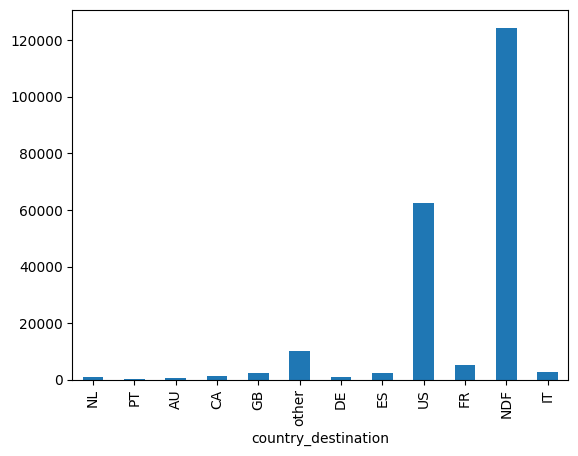

In [37]:
train_df.groupBy('country_destination').count().toPandas().set_index('country_destination').plot(kind='bar', legend=None)

#### Validating duplicates in `train_df`, `test_df`, and `sessions_df` in the following 6 cells

In [38]:
train_df.drop_duplicates().count()

213451

In [185]:
test_df.drop_duplicates().count()

62096

In [39]:
sessions_df.drop_duplicates().count()

10315201

In [40]:
train_df.select(count('id'), countDistinct('id')).show()

+---------+------------------+
|count(id)|count(DISTINCT id)|
+---------+------------------+
|   213451|            213451|
+---------+------------------+



In [187]:
test_df.select(count('id'), countDistinct('id')).show()

+---------+------------------+
|count(id)|count(DISTINCT id)|
+---------+------------------+
|    62096|             62096|
+---------+------------------+



In [41]:
sessions_df.select(count('user_id'), countDistinct('user_id')).show()

+--------------+-----------------------+
|count(user_id)|count(DISTINCT user_id)|
+--------------+-----------------------+
|      10533241|                 135483|
+--------------+-----------------------+



#### Checking nulls in `train_df`, `test_df`, and `sessions_df` in the following 3 cells

In [42]:
import pyspark.sql.functions as F
train_df.select([
                F.count(F.when(F.isnan(col) | F.col(col).isNull(), col)).alias(col)
                for col,dtype in train_df.dtypes
            ]).toPandas()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,0,0,0,124543,0,87990,0,0,0,0,0,6065,0,0,0,0


In [43]:
import pyspark.sql.functions as F
test_df.select([
                F.count(F.when(F.isnan(col) | F.col(col).isNull(), col)).alias(col)
                for col,dtype in test_df.dtypes
            ]).toPandas()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,0,0,0,62096,0,28876,0,0,0,0,0,20,0,0,0


In [44]:
sessions_df.select([
                F.count(F.when(F.isnan(col) | F.col(col).isNull(), col)).alias(col)
                for col,dtype in sessions_df.dtypes
            ]).toPandas()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,34496,79626,1126204,1126204,0,136031


## Data Pre-processing

#### Validating the values of `age` column in both `train_df` and `test_df` in the following 2 cells

In [45]:
train_df.selectExpr('min(age)','max(age)','mean(age)').show()

+--------+--------+-----------------+
|min(age)|max(age)|        mean(age)|
+--------+--------+-----------------+
|     1.0|  2014.0|49.66833517985669|
+--------+--------+-----------------+



In [46]:
test_df.selectExpr('min(age)','max(age)','mean(age)').show()

+--------+--------+-----------------+
|min(age)|max(age)|        mean(age)|
+--------+--------+-----------------+
|     1.0|  2002.0|37.61667670078266|
+--------+--------+-----------------+



#### Filling any null values in both `age` and `signup_flow` with 0 in both `train_df` and `test_df`, afterwards we'll replace the zeros of age with more meaningful values.

In [47]:
train_df = train_df.fillna(0, subset=['age'])
train_df = train_df.fillna(0, subset=['signup_flow'])

In [48]:
import pyspark.sql.functions as F
train_df.select([
                F.count(F.when(F.isnan(col) | F.col(col).isNull(), col)).alias(col)
                for col,dtype in train_df.dtypes
            ]).toPandas()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,0,0,0,124543,0,0,0,0,0,0,0,6065,0,0,0,0


In [49]:
test_df = test_df.fillna(0, subset=['age'])
test_df = test_df.fillna(0, subset=['signup_flow'])

In [50]:
import pyspark.sql.functions as F
test_df.select([
                F.count(F.when(F.isnan(col) | F.col(col).isNull(), col)).alias(col)
                for col,dtype in test_df.dtypes
            ]).toPandas()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,0,0,0,62096,0,0,0,0,0,0,0,20,0,0,0


#### The function udfAge is a PySpark user-defined function (UDF) that calculates the adjusted age based on certain conditions and returns the result.

In [51]:
from pyspark.sql.functions import udf

# Define a user-defined function to calculate adjusted age based on conditions
def udfAge(age):
    if age > 13 and age < 90:
        return age  # If age is within valid range, return the age itself
    elif age > 1940 and age < 2001:
        return 2015.0 - age  # Calculate and return the adjusted age for birth years between 1941 and 2000
    else:
        return 0.0  # Return 0.0 as default for ages that don't meet the specified conditions

# Create a handle for the udfAge function using the udf function
handleAge = udf(udfAge)

#### Using the UDF to fix the `age` in both `train_df` and `test_df`, then calculating the mean age of users in USA from the `age_df` in `m`, then using `m` to fill any zero in age in both `train_df` and `test_df` in the following 12 cells

In [52]:
train_df = train_df.withColumn("age", handleAge(train_df['age']))

In [54]:
train_df.show(5)

+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|gxn3p5htnn|          2010-06-28|        20090319043255|              null|-unknown-| 0.0|     facebook|        0.0|      en|           direct|            direct|              untracked|       Web|      Mac Desktop|       Chrome|                NDF|


In [55]:
test_df = test_df.withColumn("age", handleAge(test_df['age']))

In [56]:
test_df.show(5)

+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|
+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+
|najzl8e9p2|          2014-08-12|        20140812122406|              null|-unknown-| 0.0|        basic|        0.0|      en|           direct|            direct|                 linked|       Web|      Mac Desktop|       Safari|
|1sruvt9qya|          2014-08-05|        20140805011058|              null|-unkn

In [59]:
age_df = age_df.withColumn("population_in_thousands", age_df["population_in_thousands"].cast('float'))

In [61]:
from pyspark.sql.functions import split, col, sum, when

# Filter the age_df DataFrame to include only records where the country_destination is 'US'
age_df = age_df.filter(age_df.country_destination == 'US')

# Split the "age_bucket" column by the "-" delimiter
age_df = age_df.withColumn("age_bucket", split(col("age_bucket"), "-"))

# Calculate the sum of age times population in thousands
sum_age_times_population_in_thousands = age_df.select(
    when(age_df.age_bucket[1] == '+', 100 * age_df.population_in_thousands)
    .otherwise(((age_df.age_bucket[0] + age_df.age_bucket[1]) / 2) * age_df.population_in_thousands)
    .alias("age_times_population_in_thousands")
).agg(sum("age_times_population_in_thousands")).collect()[0][0]

# Calculate the total population by summing the "population_in_thousands" column
total_population = age_df.agg(sum("population_in_thousands")).collect()[0][0]

# Calculate the mean age by dividing the sum of age times population by the total population
mean_age = sum_age_times_population_in_thousands / total_population

# Print the mean age
print(mean_age)

38.109586260349644


In [63]:
from builtins import round
m = round(mean_age, 2)

In [64]:
m # m is the mean age of all users in USA

38.11

In [67]:
train_df = train_df.withColumn("age", when(train_df["age"] == 0.0, m).otherwise(train_df["age"]))

In [68]:
train_df.show(5)

+----------+--------------------+----------------------+------------------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender|  age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+----------+--------------------+----------------------+------------------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|gxn3p5htnn|          2010-06-28|        20090319043255|              null|-unknown-|38.11|     facebook|        0.0|      en|           direct|            direct|              untracked|       Web|      Mac Desktop|       Chrome|                N

In [69]:
test_df = test_df.withColumn("age", when(test_df["age"] == 0.0, m).otherwise(test_df["age"]))

In [70]:
test_df.show(5)

+----------+--------------------+----------------------+------------------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender|  age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|
+----------+--------------------+----------------------+------------------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+
|najzl8e9p2|          2014-08-12|        20140812122406|              null|-unknown-|38.11|        basic|        0.0|      en|           direct|            direct|                 linked|       Web|      Mac Desktop|       Safari|
|1sruvt9qya|          2014-08-05|        20140805011058|              null|-

#### In the following 4 cells, we're filling any null value in `first_affiliate_traked` column with `untracked` value, in both `train_df` and `test_df`

In [71]:
train_df  =  train_df.withColumn('first_affiliate_tracked',\
                           F.when(F.col('first_affiliate_tracked').isNull(), F.lit('untracked'))\
                            .otherwise(F.col('first_affiliate_tracked')))

In [72]:
test_df  =  test_df.withColumn('first_affiliate_tracked',\
                           F.when(F.col('first_affiliate_tracked').isNull(), F.lit('untracked'))\
                            .otherwise(F.col('first_affiliate_tracked')))

In [73]:
train_df.show(5)

+----------+--------------------+----------------------+------------------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender|  age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+----------+--------------------+----------------------+------------------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|gxn3p5htnn|          2010-06-28|        20090319043255|              null|-unknown-|38.11|     facebook|        0.0|      en|           direct|            direct|              untracked|       Web|      Mac Desktop|       Chrome|                N

In [74]:
test_df.show(5)

+----------+--------------------+----------------------+------------------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender|  age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|
+----------+--------------------+----------------------+------------------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+
|najzl8e9p2|          2014-08-12|        20140812122406|              null|-unknown-|38.11|        basic|        0.0|      en|           direct|            direct|                 linked|       Web|      Mac Desktop|       Safari|
|1sruvt9qya|          2014-08-05|        20140805011058|              null|-

## Feature Engineering

#### We're dropiing the `date_account_created`, `timestamp_first_active`, `date_first_booking` columns, from both `train_df` and `test_df`, in the following 4 cells

In [75]:
columns_to_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking']
train_df = train_df.drop(*columns_to_drop)
test_df = test_df.drop(*columns_to_drop)

In [76]:
train_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: float (nullable = false)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)



In [77]:
test_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: float (nullable = false)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)



In [78]:
train_df.show(5)

+----------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|        id|   gender|  age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+----------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|gxn3p5htnn|-unknown-|38.11|     facebook|        0.0|      en|           direct|            direct|              untracked|       Web|      Mac Desktop|       Chrome|                NDF|
|820tgsjxq7|     MALE| 38.0|     facebook|        0.0|      en|              seo|            google|              untracked|       Web|      Mac Desktop|       Chrome|                NDF|
|4ft3gnwmtx|   FEMALE| 56.0|        basic|        3.0|      

In [79]:
test_df.show(5)

+----------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+
|        id|   gender|  age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|
+----------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+
|0crstf67x4|     MALE| 36.0|        basic|        0.0|      en|        sem-brand|            google|                    omg|       Web|  Windows Desktop|      Firefox|
|5j31dfjw6j|-unknown-|38.11|        basic|        0.0|      en|        sem-brand|            google|                    omg|       Web|      Mac Desktop|       Safari|
|3t0af4jj7l|-unknown-|38.11|        basic|        0.0|      en|           direct|            direct|              untracked|       Web|  Windows Desktop|       

#### In the `sessions_df` we're filling any `-unknown-` value in both `action_type` and `device_type` columns with `None`

In [80]:
sessions_df  =  sessions_df.withColumn('action_type',\
                                F.when(F.col('action_type') == '-unknown-', F.lit(None))\
                                .otherwise(F.col('action_type')))\
                            .withColumn('device_type',\
                                F.when(F.col('device_type') == '-unknown-', F.lit(None))\
                                .otherwise(F.col('device_type')))

#### In the cell below, we're getting all unique values of both `action_type` and `device_type` columns from the `sessions_df`

In [81]:
action_types = sessions_df.select(F.collect_set('action_type').alias('action_type')).first()['action_type']
print(action_types)
device_types = sessions_df.select(F.collect_set('device_type').alias('device_type')).first()['device_type']
print(device_types)

['booking_response', 'click', 'message_post', 'data', 'view', 'modify', 'partner_callback', 'booking_request', 'submit']


['Android App Unknown Phone/Tablet', 'iPad Tablet', 'Windows Phone', 'Chromebook', 'iPhone', 'Opera Phone', 'Linux Desktop', 'Tablet', 'Mac Desktop', 'iPodtouch', 'Blackberry', 'Android Phone', 'Windows Desktop']


#### Below we're grouping the `sessions_df` by `user_id` column, and aggergating the `device_type` and `action_type` columns with their sets, and summing the `secs_elapsed` column

In [82]:
sessions_df = sessions_df\
            .groupby("user_id")\
            .agg(F.collect_set("device_type").alias('device_type'),\
                    F.sum("secs_elapsed").alias('secs_elapsed'),\
                    F.collect_set("action_type").alias('action_type'))

#### In the cell below, we're adding a column for each value for both `device_type` and `action_type` and putting 1 if this was the actual value, else 0 [The idea of get_dummies]

In [83]:
columns_distict_values_to_convert = {'device_type': device_types, 'action_type':action_types}
columns_to_convert = ['action_type','device_type']
for column in columns_to_convert:
    for value in columns_distict_values_to_convert[column]:
        sessions_df = sessions_df.withColumn(value, F.array_contains(column, value).cast("int"))
        
sessions_df = sessions_df.drop(*columns_to_convert)

In [84]:
sessions_df.show(5)

+----------+------------+----------------+-----+------------+----+----+------+----------------+---------------+------+--------------------------------+-----------+-------------+----------+------+-----------+-------------+------+-----------+---------+----------+-------------+---------------+
|   user_id|secs_elapsed|booking_response|click|message_post|data|view|modify|partner_callback|booking_request|submit|Android App Unknown Phone/Tablet|iPad Tablet|Windows Phone|Chromebook|iPhone|Opera Phone|Linux Desktop|Tablet|Mac Desktop|iPodtouch|Blackberry|Android Phone|Windows Desktop|
+----------+------------+----------------+-----+------------+----+----+------+----------------+---------------+------+--------------------------------+-----------+-------------+----------+------+-----------+-------------+------+-----------+---------+----------+-------------+---------------+
|      null|6.02297414E8|               0|    1|           1|   1|   1|     1|               1|              1|     1|      

#### Below we're joining the `train_df` and `sessions_df` on the `id` of the user, using inner join

In [85]:
train_merged = train_df.join(sessions_df,(train_df.id == sessions_df.user_id ),"inner")

train_merged = train_merged.na.fill(0,[value for column in columns_to_convert for value in columns_distict_values_to_convert[column]])

In [86]:
train_merged.show(5)

+----------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+----------+------------+----------------+-----+------------+----+----+------+----------------+---------------+------+--------------------------------+-----------+-------------+----------+------+-----------+-------------+------+-----------+---------+----------+-------------+---------------+
|        id|   gender|  age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|   user_id|secs_elapsed|booking_response|click|message_post|data|view|modify|partner_callback|booking_request|submit|Android App Unknown Phone/Tablet|iPad Tablet|Windows Phone|Chromebook|iPhone|Opera Phone|Linux Desktop|Tablet|Mac Desktop|iPodtouch|Blackberry|Android Phone|Windows Desktop|
+----------+---------+-----+-------------+--

#### Filling any null value in the merged_dataset with 0 in the `secs_elapsed` column

In [87]:
train_merged = train_merged.fillna(0, subset=['secs_elapsed'])

#### Checking the nulls in the `train_merged` dataframe

In [88]:
import pyspark.sql.functions as F
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
train_merged.select([
                F.count(F.when(F.isnan(col) | F.col(col).isNull(), col)).alias(col)
                for col,dtype in train_merged.dtypes
            ]).toPandas()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,user_id,secs_elapsed,booking_response,click,message_post,data,view,modify,partner_callback,booking_request,submit,Android App Unknown Phone/Tablet,iPad Tablet,Windows Phone,Chromebook,iPhone,Opera Phone,Linux Desktop,Tablet,Mac Desktop,iPodtouch,Blackberry,Android Phone,Windows Desktop
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Below we're joining the `test_df` and `sessions_df` on the `id` of the user, using left join on the `test_df`

In [89]:
test_merged = test_df.join(sessions_df,(test_df.id == sessions_df.user_id ),"left")

test_merged = test_merged.na.fill(0,[value for column in columns_to_convert for value in columns_distict_values_to_convert[column]])

#### Filling any null value in the merged_dataset with 0 in the `secs_elapsed` column

In [91]:
test_merged = test_merged.fillna(0, subset=['secs_elapsed'])

#### Checking the nulls in the `test_merged` dataframe

In [90]:
import pyspark.sql.functions as F
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
test_merged.select([
                F.count(F.when(F.isnan(col) | F.col(col).isNull(), col)).alias(col)
                for col,dtype in test_merged.dtypes
            ]).toPandas()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,user_id,secs_elapsed,booking_response,click,message_post,data,view,modify,partner_callback,booking_request,submit,Android App Unknown Phone/Tablet,iPad Tablet,Windows Phone,Chromebook,iPhone,Opera Phone,Linux Desktop,Tablet,Mac Desktop,iPodtouch,Blackberry,Android Phone,Windows Desktop
0,0,0,0,0,0,0,0,0,0,0,0,0,428,670,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
test_merged.printSchema()

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: float (nullable = false)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- secs_elapsed: double (nullable = false)
 |-- booking_response: integer (nullable = true)
 |-- click: integer (nullable = true)
 |-- message_post: integer (nullable = true)
 |-- data: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- modify: integer (nullable = true)
 |-- partner_callback: integer (nullable = true)
 |-- booking_request: integer (nullable = true)
 |-- submit: integer (nullable = true)
 |-- 

In [93]:
test_merged.show(5)

+----------+---------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+----------+------------+----------------+-----+------------+----+----+------+----------------+---------------+------+--------------------------------+-----------+-------------+----------+------+-----------+-------------+------+-----------+---------+----------+-------------+---------------+
|        id|   gender|  age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|   user_id|secs_elapsed|booking_response|click|message_post|data|view|modify|partner_callback|booking_request|submit|Android App Unknown Phone/Tablet|iPad Tablet|Windows Phone|Chromebook|iPhone|Opera Phone|Linux Desktop|Tablet|Mac Desktop|iPodtouch|Blackberry|Android Phone|Windows Desktop|
+----------+---------+-----+-------------+-----------+--------+-----------------+---

#### In the next 2 cells, we're getting the numerical and categorical columns

In [94]:
numericalColumns = [c[0] for c in train_merged.dtypes if c[1] in ('int', 'bigint', 'float', 'double')]
numericalColumns

['signup_flow',
 'secs_elapsed',
 'booking_response',
 'click',
 'message_post',
 'data',
 'view',
 'modify',
 'partner_callback',
 'booking_request',
 'submit',
 'Android App Unknown Phone/Tablet',
 'iPad Tablet',
 'Windows Phone',
 'Chromebook',
 'iPhone',
 'Opera Phone',
 'Linux Desktop',
 'Tablet',
 'Mac Desktop',
 'iPodtouch',
 'Blackberry',
 'Android Phone',
 'Windows Desktop']

In [95]:
categoricalColumns = [item[0] for item in train_merged.dtypes if item[1].startswith('string')] 
categoricalColumns.pop(-1)
categoricalColumns

['id',
 'gender',
 'age',
 'signup_method',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination']

## ML Model

#### In the cell below we're converting the categorical columns to INDEXED columns

In [99]:
#convert the categorical columns into numerical indices
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
colss = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_INDEX").fit(train_merged) for column in colss]
pipeline = Pipeline(stages=indexers)
train_merged_2 = pipeline.fit(train_merged).transform(train_merged)

#### In the cell below, we're using the NHE, to convert the INDEXED columns to ENCODED values for each one

In [101]:
#one-hot encoded columns into a single vector column 
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
cat_cols = ['gender_INDEX', 'signup_method_INDEX', 'language_INDEX', 'affiliate_channel_INDEX', 'affiliate_provider_INDEX', 'first_affiliate_tracked_INDEX', 'signup_app_INDEX', 'first_device_type_INDEX', 'first_browser_INDEX']

ohe_encoders = [OneHotEncoder(inputCol=column, outputCol="{0}_ENCODED".format(column)).fit(train_merged_2) for column in cat_cols]

assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in ohe_encoders],outputCol="features")

pipeline = Pipeline(stages=ohe_encoders)
train_merged_2 = pipeline.fit(train_merged_2).transform(train_merged_2)

#### Now, we're ready to drop the actual and INDEXED columns

In [102]:
toDropColumns = ['user_id', 'gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'gender_INDEX', 'signup_method_INDEX', 'language_INDEX', 'affiliate_channel_INDEX', 'affiliate_provider_INDEX', 'first_affiliate_tracked_INDEX', 'signup_app_INDEX', 'first_device_type_INDEX', 'first_browser_INDEX']
train_merged_2 = train_merged_2.drop(*toDropColumns)

#### Dobule check casting the age column again

In [103]:
train_merged_2 = train_merged_2.withColumn("age", train_merged_2["age"].cast('float'))

In [105]:
from pyspark.ml.feature import VectorAssembler
assembler_inputs = [c for c in train_merged_2.columns if c not in ['country_destination', 'id']]
vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
train_merged_3 = vec_assembler.transform(train_merged_2).drop(*assembler_inputs)

In [106]:
train_merged_3.show(5)

+----------+-------------------+--------------------+
|        id|country_destination|            features|
+----------+-------------------+--------------------+
|00b9hfwaak|                 US|(127,[0,2,4,6,7,1...|
|00e4nxhdvv|                 ES|(127,[0,2,6,7,11,...|
|00fyswof3k|                 US|(127,[0,2,4,6,7,1...|
|00g3pdo41k|                NDF|(127,[0,1,2,4,6,7...|
|00j993htr2|                 US|(127,[0,2,4,6,7,1...|
+----------+-------------------+--------------------+
only showing top 5 rows



#### Then we need to convert the target values in `country_destination` to numerical values

In [107]:
indexer = StringIndexer(inputCol='country_destination', outputCol='label')
train_merged_4 = indexer.fit(train_merged_3).transform(train_merged_3)
label_keys = sorted(set([(i[0], i[1]) for i in train_merged_4.select(train_merged_4.country_destination, train_merged_4.label).collect()]), key=lambda x: x[0])
label_keys = {int(i[1]):i[0] for i in label_keys}

In [108]:
label_keys

{10: 'AU',
 7: 'CA',
 8: 'DE',
 6: 'ES',
 3: 'FR',
 5: 'GB',
 4: 'IT',
 0: 'NDF',
 9: 'NL',
 11: 'PT',
 1: 'US',
 2: 'other'}

In [109]:
train_merged_4.select('features', 'label').show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(127,[0,2,4,6,7,1...|  1.0|
|(127,[0,2,6,7,11,...|  6.0|
|(127,[0,2,4,6,7,1...|  1.0|
|(127,[0,1,2,4,6,7...|  0.0|
|(127,[0,2,4,6,7,1...|  1.0|
|(127,[0,2,5,6,11,...|  0.0|
|(127,[0,2,4,5,6,7...|  1.0|
|(127,[0,1,2,4,6,7...|  0.0|
|(127,[0,2,4,5,6,7...|  3.0|
|(127,[0,1,2,6,7,1...|  0.0|
|(127,[0,1,2,4,6,7...|  0.0|
|(127,[0,2,4,5,6,7...|  1.0|
|(127,[0,2,4,5,6,7...|  1.0|
|(127,[0,1,2,4,5,6...|  0.0|
|(127,[0,2,4,5,6,7...|  0.0|
|(127,[0,2,4,6,7,9...|  0.0|
|(127,[0,2,4,6,7,1...|  0.0|
|(127,[0,2,4,5,6,7...|  1.0|
|(127,[0,1,2,4,5,6...|  1.0|
|(127,[0,2,4,6,7,1...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [110]:
trainingData = train_merged_4

#### Below we will fit the `DecisionTreeClassifier` on the `trainingData`, then we will validate with the same data as we need a reference to help us evaluate the accuracy of the model

In [111]:
from pyspark.ml.classification import DecisionTreeClassifier
model = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model = model.fit(trainingData)
validation_predictions_decision_tree = model.transform(trainingData)
validation_predictions_decision_tree.show(5)

+----------+-------------------+--------------------+-----+--------------------+--------------------+----------+
|        id|country_destination|            features|label|       rawPrediction|         probability|prediction|
+----------+-------------------+--------------------+-----+--------------------+--------------------+----------+
|00b9hfwaak|                 US|(127,[0,2,4,6,7,1...|  1.0|[25877.0,2496.0,6...|[0.86380478686116...|       0.0|
|00e4nxhdvv|                 ES|(127,[0,2,6,7,11,...|  6.0|[7588.0,2951.0,51...|[0.65116279069767...|       0.0|
|00fyswof3k|                 US|(127,[0,2,4,6,7,1...|  1.0|[397.0,226.0,38.0...|[0.51491569390402...|       0.0|
|00g3pdo41k|                NDF|(127,[0,1,2,4,6,7...|  0.0|[25877.0,2496.0,6...|[0.86380478686116...|       0.0|
|00j993htr2|                 US|(127,[0,2,4,6,7,1...|  1.0|[74.0,44.0,10.0,3...|[0.52857142857142...|       0.0|
+----------+-------------------+--------------------+-----+--------------------+----------------

#### In the following 9 cells, we will apply the same data pre-processing and transformations on the `test_merged` df, so it will be ready to be used in the submission phase

In [113]:
numericalColumns = [c[0] for c in test_merged.dtypes if c[1] in ('int', 'bigint', 'float', 'double')]
numericalColumns

['signup_flow',
 'secs_elapsed',
 'booking_response',
 'click',
 'message_post',
 'data',
 'view',
 'modify',
 'partner_callback',
 'booking_request',
 'submit',
 'Android App Unknown Phone/Tablet',
 'iPad Tablet',
 'Windows Phone',
 'Chromebook',
 'iPhone',
 'Opera Phone',
 'Linux Desktop',
 'Tablet',
 'Mac Desktop',
 'iPodtouch',
 'Blackberry',
 'Android Phone',
 'Windows Desktop']

In [114]:
categoricalColumns = [item[0] for item in test_merged.dtypes if item[1].startswith('string')] 
categoricalColumns.pop(-1)
categoricalColumns

['id',
 'gender',
 'age',
 'signup_method',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser']

In [115]:
test_merged.printSchema()

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: float (nullable = false)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- secs_elapsed: double (nullable = false)
 |-- booking_response: integer (nullable = true)
 |-- click: integer (nullable = true)
 |-- message_post: integer (nullable = true)
 |-- data: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- modify: integer (nullable = true)
 |-- partner_callback: integer (nullable = true)
 |-- booking_request: integer (nullable = true)
 |-- submit: integer (nullable = true)
 |-- 

In [116]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
colss = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_INDEX").fit(test_merged) for column in colss]
pipeline = Pipeline(stages=indexers)
test_merged_2 = pipeline.fit(test_merged).transform(test_merged)

In [117]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
cat_cols = ['gender_INDEX', 'signup_method_INDEX', 'language_INDEX', 'affiliate_channel_INDEX', 'affiliate_provider_INDEX', 'first_affiliate_tracked_INDEX', 'signup_app_INDEX', 'first_device_type_INDEX', 'first_browser_INDEX']

ohe_encoders = [OneHotEncoder(inputCol=column, outputCol="{0}_ENCODED".format(column)).fit(test_merged_2) for column in cat_cols]

assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in ohe_encoders],outputCol="features")

pipeline = Pipeline(stages=ohe_encoders)
test_merged_2 = pipeline.fit(test_merged_2).transform(test_merged_2)

In [118]:
toDropColumns = ['user_id', 'gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'gender_INDEX', 'signup_method_INDEX', 'language_INDEX', 'affiliate_channel_INDEX', 'affiliate_provider_INDEX', 'first_affiliate_tracked_INDEX', 'signup_app_INDEX', 'first_device_type_INDEX', 'first_browser_INDEX']
test_merged_2 = test_merged_2.drop(*toDropColumns)

In [119]:
test_merged_2 = test_merged_2.withColumn("age", test_merged_2["age"].cast('float'))

In [120]:
from pyspark.ml.feature import VectorAssembler
assembler_inputs = [c for c in test_merged_2.columns if c not in ['country_destination', 'id']]
vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
test_merged_3 = vec_assembler.transform(test_merged_2).drop(*assembler_inputs)

In [121]:
test_merged_3.show(5)

+----------+--------------------+
|        id|            features|
+----------+--------------------+
|0010k6l0om|(123,[0,2,4,6,7,9...|
|005v5uf4dh|(123,[0,1,2,4,6,7...|
|0063bawn05|(123,[0,2,6,7,11,...|
|00dj8as8yl|(123,[0,2,4,5,6,7...|
|00jcwpqbl2|(123,[0,2,4,7,16,...|
+----------+--------------------+
only showing top 5 rows



## Evaluation

#### The `cop_train` df is a copy of `validation_predictions_decision_tree` returned from running the trained model on the `trainingData`, it contains the actual and predicted value

In [159]:
cop_train = validation_predictions_decision_tree.select("*")

In [129]:
cop_train.columns

['id',
 'country_destination',
 'features',
 'label',
 'rawPrediction',
 'probability',
 'prediction']

In [135]:
cop_train.count()

73815

#### Below we're checking the accuracy by testing the number of correct predictions according to the actual values in `label` column

In [125]:
from pyspark.sql.functions import col

correctPredictions = cop_train.filter(col("label") == col("prediction")).count()
totalPredictions = cop_train.count()

accuracy = correctPredictions / totalPredictions
accuracy

0.6910248594459121

#### To calculate the NDCG @ k=5, we're using the `RankingEvaluator` from Pyspark ml library

#### Running the NDCG evaluation gives a massive output of WARN, we validated the warning is not from our side, because the code from the official documentation does the same, so after running the cell, we immediately removed the cell output which makes the cell appears did not run before, we just wanted to clarify this

In [ ]:
from pyspark.ml.evaluation import RankingEvaluator

evaluator = RankingEvaluator()
evaluator.setPredictionCol("prediction")
cop_train_2 = cop_train.select(['label', 'prediction']).withColumn("prediction", array(cop_train["prediction"]))
cop_train_3 = cop_train_2.withColumn("label", array(cop_train_2["label"]))
evaluator.evaluate(cop_train_3.select(['label', 'prediction']))
ndcgAt5 = evaluator.evaluate(cop_train_3, {evaluator.metricName: "ndcgAtK", evaluator.k: 5})

In [188]:
ndcgAt5

0.6910248594459137

# Submitting to Kaggle

#### Below we're running our model and predicting the `country_destination` for the `test_merged` df

In [189]:
from pyspark.ml.classification import DecisionTreeClassifier
model = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model = model.fit(trainingData)
test_after_model = model.transform(test_merged_3)
test_after_model.show(5)

+----------+--------------------+--------------------+--------------------+----------+
|        id|            features|       rawPrediction|         probability|prediction|
+----------+--------------------+--------------------+--------------------+----------+
|0010k6l0om|(123,[0,2,4,6,7,9...|[25877.0,2496.0,6...|[0.86380478686116...|       0.0|
|005v5uf4dh|(123,[0,1,2,4,6,7...|[25877.0,2496.0,6...|[0.86380478686116...|       0.0|
|0063bawn05|(123,[0,2,6,7,11,...|[2812.0,727.0,129...|[0.73038961038961...|       0.0|
|00dj8as8yl|(123,[0,2,4,5,6,7...|[1184.0,5517.0,85...|[0.13336337012840...|       1.0|
|00jcwpqbl2|(123,[0,2,4,7,16,...|[2812.0,727.0,129...|[0.73038961038961...|       0.0|
+----------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



#### We're selecting the `id` and `prediction` columns from the `test_predictions_decision_tree` df

In [279]:
y_predict = test_after_model.select(['probability', 'id'])
y_predict

DataFrame[probability: vector, id: string]

In [280]:
y_predict.printSchema()

root
 |-- probability: vector (nullable = true)
 |-- id: string (nullable = true)



In [281]:
y_predict.show(1, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|probability                                                                                                                                                                                                                                                  |id        |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|[0.8638047868611677,0.08331942450846212,0.022799345728878057,0.008412057282104349,0.006909904196014287,0.004306172180124845,0.0042060286410521746,0.002303301398671429,0.0012351036485629403,0.0012351

#### A UDF to sort the predictions in descending order and return the top 5

In [282]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.types import ArrayType, StringType

# Create a UDF to convert the vector to a list of sorted labels
@udf(returnType=ArrayType(StringType()))
def get_sorted_labels(vector):
    sorted_labels = np.flip(np.argsort(vector))[:5]
    return [label_keys[j] for j in sorted_labels]

# Apply the UDF to the y_predict DataFrame
y_predict = y_predict.withColumn("predictions", get_sorted_labels("probability"))

In [283]:
y_predict.show(5, truncate=False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------------------+
|probability                                                                                                                                                                                                                                                  |id        |predictions             |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------------------+
|[0.8638047868611677,0.08331942450846212,0.022799345728878057,0.008412057282104349,0.006909904196014287,0.004306172180124845

#### Selecting the `id` from `test_df`

In [284]:
# Select the 'id' column and collect the values as a list
test_ids = test_df.select(['id'])
# Show the test_id_values
test_ids.show(5)

+----------+
|        id|
+----------+
|9m874n5xsz|
|nwbnykj733|
|xvo3tqpw23|
|9z69xpcvdr|
|v2dieulde9|
+----------+
only showing top 5 rows



In [285]:
test_ids.count()

62096

In [286]:
y_predict.count()

62096

In [287]:
y_predict.printSchema()

root
 |-- probability: vector (nullable = true)
 |-- id: string (nullable = true)
 |-- predictions: array (nullable = true)
 |    |-- element: string (containsNull = true)



#### Adding 5 columns for each of the top 5 predictions

In [288]:
from pyspark.sql.functions import col, array, lit

# Convert the predictions DataFrame to PySpark DataFrame
y_predict = y_predict.select([*[col("predictions")[i].alias("prediction_" + str(i + 1)) for i in range(5)],'id'])

In [289]:
y_predict.printSchema()

root
 |-- prediction_1: string (nullable = true)
 |-- prediction_2: string (nullable = true)
 |-- prediction_3: string (nullable = true)
 |-- prediction_4: string (nullable = true)
 |-- prediction_5: string (nullable = true)
 |-- id: string (nullable = true)



#### Joining the `ids` with the `predictions` on the `id` column

In [290]:
joined_df = test_ids.join(y_predict, on='id', how='inner')

In [291]:
joined_df.show(20)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+----------+------------+------------+------------+------------+------------+
|        id|prediction_1|prediction_2|prediction_3|prediction_4|prediction_5|
+----------+------------+------------+------------+------------+------------+
|0010k6l0om|         NDF|          US|       other|          FR|          IT|
|005v5uf4dh|         NDF|          US|       other|          FR|          IT|
|0063bawn05|         NDF|          US|       other|          FR|          IT|
|00dj8as8yl|          US|         NDF|       other|          FR|          IT|
|00jcwpqbl2|         NDF|          US|       other|          FR|          IT|
|00kbbr6qom|         NDF|          US|       other|          FR|          IT|
|00rudms01g|          US|         NDF|       other|          FR|          IT|
|00ycgxqszj|         NDF|          US|       other|          FR|          IT|
|00zmemwtfc|         NDF|          US|       other|          IT|          FR|
|01154kld3t|          US|         NDF|       other|          FR|

In [292]:
joined_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- prediction_1: string (nullable = true)
 |-- prediction_2: string (nullable = true)
 |-- prediction_3: string (nullable = true)
 |-- prediction_4: string (nullable = true)
 |-- prediction_5: string (nullable = true)



#### Selecting the `id` and the first prediction column

In [293]:
from pyspark.sql.functions import col

# Select the desired columns from predictions_df
joined_df_final = joined_df.select(col("id"), col("prediction_1"))

In [294]:
joined_df_final.show(5)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+----------+------------+
|        id|prediction_1|
+----------+------------+
|0010k6l0om|         NDF|
|005v5uf4dh|         NDF|
|0063bawn05|         NDF|
|00dj8as8yl|          US|
|00jcwpqbl2|         NDF|
+----------+------------+
only showing top 5 rows



#### Renaming the columns to match the submission file

In [295]:
joined_df_final = joined_df_final.withColumnRenamed("prediction_1", "country")

In [298]:
joined_df_final.printSchema()

root
 |-- id: string (nullable = true)
 |-- country: string (nullable = true)



In [305]:
joined_df_final.count()

62096

In [304]:
joined_df_final.show()

+----------+-------+
|        id|country|
+----------+-------+
|0010k6l0om|    NDF|
|005v5uf4dh|    NDF|
|0063bawn05|    NDF|
|00dj8as8yl|     US|
|00jcwpqbl2|    NDF|
|00kbbr6qom|    NDF|
|00rudms01g|     US|
|00ycgxqszj|    NDF|
|00zmemwtfc|    NDF|
|01154kld3t|     US|
|017rmzerma|    NDF|
|017xmi55i2|    NDF|
|01abo5ge4d|    NDF|
|01dh6l1e0v|    NDF|
|01dq5wt9wi|    NDF|
|01fg7p4sw4|     US|
|01hwxjvgv9|     US|
|01l0vcvuks|    NDF|
|01nvbbx1ex|    NDF|
|01p6v22cpv|     US|
+----------+-------+
only showing top 20 rows



#### Saving the submission file

In [307]:
# Assuming you have a PySpark DataFrame called 'df'
joined_df_final.repartition(1).write.csv('submissions_2.csv', header=True, mode='overwrite')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
